epoch 1, loss 0.035655
epoch 2, loss 0.000134
epoch 3, loss 0.000051


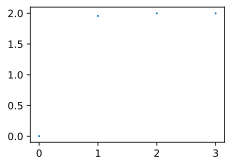

In [2]:
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) # 样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        a = indices[i: min(i + batch_size, num_examples)]
        j = torch.LongTensor(a) # 最后⼀次可能不⾜⼀个batch
        yield features.index_select(0, j), labels.index_select(0, j)

class LinregModel():
    def net(self, X, w, b):
        return self.linreg(X, w, b)

    def linreg(self, X, w, b): # 本函数已保存在d2lzh_pytorch包中⽅便以后使⽤
        return torch.mm(X, w) + b

    def loss(self, y_hat, y):
        return self.squared_loss(y_hat, y)

    def squared_loss(self, y_hat, y): # 本函数已保存在d2lzh_pytorch包中⽅便以后使⽤
    # 注意这⾥返回的是向量, 另外, pytorch⾥的MSELoss并没有除以 2
        return (y_hat - y.view(y_hat.size())) ** 2 / 2

    def sgd(self, params, lr, batch_size): # 本函数已保存在d2lzh_pytorch包中⽅便以后使⽤
        for param in params:
            param.data -= lr * param.grad / batch_size # 注意这⾥更改param时⽤的param.data

class Train():
    def __init__(self, batch_size, lr, num_epochs, model):
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.model = model
    def run(self, features, labels, num_inputs, data_collector):
        w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.double)
        b = torch.zeros(1, dtype=torch.double)
        w.requires_grad_(requires_grad=True)
        b.requires_grad_(requires_grad=True)
        data_collector.collect_parameter(w, b)
        for epoch in range(self.num_epochs):  # 训练模型⼀共需要num_epochs个迭代周期
            # 在每⼀个迭代周期中，会使⽤训练数据集中所有样本⼀次（假设样本数能够被批量⼤⼩整除）。 X
            # 和y分别是⼩批量样本的特征和标签
            for X, y in data_iter(self.batch_size, features, labels):
                l = self.model.loss(self.model.net(X, w, b), y).sum()  # l是有关⼩批量X和y的损失
                l.backward()  # ⼩批量的损失对模型参数求梯度
                self.model.sgd([w, b], self.lr, self.batch_size)  # 使⽤⼩批量随机梯度下降迭代模型参数
                # 不要忘了梯度清零
                w.grad.data.zero_()
                b.grad.data.zero_()
            train_l = self.model.loss(self.model.net(features, w, b), labels)
            print('epoch %d, loss %f' % (epoch + 1, train_l.mean().item()))
            data_collector.collect_parameter(w, b)

class DataCollector():
    def hyperparameter(self, batch_size, lr, num_epochs):
        self.batch_size = batch_size
        self.lr = lr
        self.num_epochs = num_epochs
        self.l_w = []
    def collect_parameter(self, w, b):
        self.l_w.append(w.clone().detach().numpy().reshape(2).tolist())

class Drawer():
    def __init__(self):
        self.set_figsize()

    def use_svg_display(self):
        # ⽤⽮量图显示
        display.set_matplotlib_formats('svg')

    def set_figsize(self, figsize=(3.5, 2.5)):
        self.use_svg_display()
        # 设置图的尺⼨
        plt.rcParams['figure.figsize'] = figsize

    def draw(self, data_collector):
        plt.figure()
        a = np.array(data_collector.l_w)
        plt.scatter(range(data_collector.num_epochs + 1), np.array(data_collector.l_w)[:, 0], 1)
        plt.show()
#生成训练数据
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.from_numpy(np.random.normal(0, 1, (num_examples, num_inputs)))
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.from_numpy(np.random.normal(0, 0.01, size=labels.size()))

#训练
train = Train(batch_size=10, lr = 0.03, num_epochs = 3, model=LinregModel())
data_collector = DataCollector()
data_collector.hyperparameter(batch_size=10, lr = 0.03, num_epochs = 3)
train.run(features, labels, num_inputs, data_collector)

#绘图
drawer = Drawer()
drawer.draw(data_collector)